In [14]:
from skfuzzy import control as ctrl
import skfuzzy as fuzz
import numpy as np

In [8]:
'''
RULES:

if NUM_PIECES is 'HIGH' then 'opening'
if NUM_PIECES is 'MEDIUM' then 'middlegame'
if NUM_PIECES is 'LOW' then 'endgame'


if NUM_MOVES <= 20 then 'opening'
if NUM_MOVES > 20 and NUM_MOVES <= 40 then 'middlegame'
if NUM_MOVES > 40 then 'endgame'

if BLACK_KING_FILE is 'advanced' AND WHITE_KING_FILE is 'advanced' then 'endgame'
if BLACK_KING_FILE is 'advanced' XOR WHITE_KING_FILE is 'advanced' then 'middlegame'
if BLACK_KING_FILE is not 'advanced' AND WHITE_KING_FILE is note 'advanced' then 'opening'
'''

"\nRULES:\n\nif NUM_PIECES >= 24 then 'opening'\nif NUM_PIECES < 24 and NUM_MOVES >= 12 then 'middlegame'\nif NUM_PIECES < 12 then 'endgame'\n\n\nif NUM_MOVES <= 20 then 'opening'\nif NUM_MOVES > 20 and NUM_MOVES <= 40 then 'middlegame'\nif NUM_MOVES > 40 then 'endgame'\n\nif WHITE_KING_FILE > 2 then 'endgame'\nif BLACK_KING_FILE < 7 then 'endgame'\n"

In [11]:
# Create universe of discourse
universe = np.linspace(0, 1, 50)

# Create fuzzy variables
num_pieces = ctrl.Antecedent(np.arange(2, 33, 1), 'num_pieces')
num_moves = ctrl.Antecedent(np.arange(0, 150, 1), 'num_moves')
king_advanced_squares = ctrl.Antecedent(np.arange(0,9,1), 'king_advanced_squares')

In [19]:
# Populate the fuzzy variables with membership functions
num_pieces['LOW'] = fuzz.trimf(num_pieces.universe, [0, 15, 31])

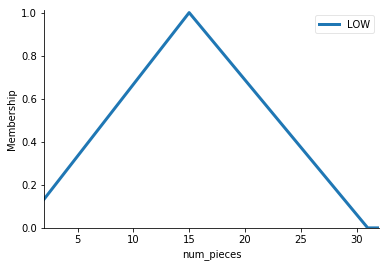

In [20]:
num_pieces['LOW'].view()